In [1]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_product, matrix_transpose, rotation_matrix
from astropy.io import ascii
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import os.path
 

In [2]:
class ArbitraryPoleFrame(coord.BaseCoordinateFrame):

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential:[
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    pole = coord.CoordinateAttribute(frame=coord.ICRS)
    roll = coord.QuantityAttribute(default=0*u.degree)


@frame_transform_graph.transform(coord.DynamicMatrixTransform, coord.ICRS, ArbitraryPoleFrame)
def icrs_to_arbpole(icrs_coord, arbpole_frame):

    roll = arbpole_frame.roll
    pole = arbpole_frame.pole

    # Align z(new) with direction to M31
    mat1 = rotation_matrix(-pole.dec, 'y')
    mat2 = rotation_matrix(pole.ra, 'z')
    mat3 = rotation_matrix(roll, 'z')
    mat4 = rotation_matrix(90*u.degree, 'y')
    R = matrix_product(mat4, mat1, mat2, mat3)

    return R


@frame_transform_graph.transform(coord.DynamicMatrixTransform, ArbitraryPoleFrame, coord.ICRS)
def arbpole_to_icrs(arbpole_coord, icrs_frame):
    return matrix_transpose(icrs_to_arbpole(None, arbpole_coord))

def plotFootprint(x, y, filename, nbins=250):
    fig2, axes = plt.subplots()#1, 3, figsize=(15, 5))
    H, xedges, yedges = np.histogram2d(x, y, bins=(nbins, nbins))
    axes.pcolormesh(xedges, yedges, H.T, norm=mpl.colors.LogNorm(vmin=10, vmax=1000))
    plt.ylabel('phi2')
    plt.xlabel('phi1')
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(10,10)
    fig.savefig(filename, rasterized=True)
    return fig2, axes

def plotStream(l, b, ra, dec, lpoles, bpoles, phi1s, filenameGal ='all.png', filenameEq = 'all.png'):
    #SNindex = (data['s2n'] <= 10) & (data['s2n'] > 5)
    figGal, axGal = plotFootprint(l, b, None, nbins=500)
    figEq, axEq = plotFootprint(ra, dec, None, nbins=500)
    phi1 = np.linspace(0, 360.00001, 1024)
    phi2 = np.zeros(len(phi1))
    for lpole, bpole, phi1mid in zip(lpoles, bpoles, phi1s):
        pole = coord.Galactic(l=lpole*u.deg, b=bpole*u.deg)
        index = (phi1 <= phi1mid+5) & (phi1 >= phi1mid-5)
        testobserved = ArbitraryPoleFrame(phi1=phi1[index]*u.deg, phi2=phi2[index]*u.deg, pole=pole)
        gal = testobserved.transform_to(coord.Galactic)
        eq = testobserved.transform_to(coord.ICRS)
        axGal.scatter(gal.l, gal.b, s=1, alpha=0.1, c='black')
        axEq.scatter(eq.ra, eq.dec, s=1, alpha=0.1, c='black')
    for ax in [axGal, axEq]: ax.set_xlim(0, 360)
    axGal.set_ylim(-90, 90)
    axGal.set_xlabel('l')
    axGal.set_ylabel('b')
    axEq.set_ylim(-30, 90)
    axEq.set_xlabel('ra')
    axEq.set_ylabel('dec')
    figGal.savefig(filenameGal)
    figEq.savefig(filenameEq)

In [3]:
picklefile = 'gaiasdssHaloNew_30b_dustcorrected_python3.pkl'
with open(picklefile, 'rb') as f:
    stars = pickle.load(f)

In [8]:
streamfile = 'detections_distance10_nside128.txt'
data = ascii.read(streamfile)

In [9]:
data.keys()

['l', 'b', 'phi1', 'muphi1', 's2n', 'n']

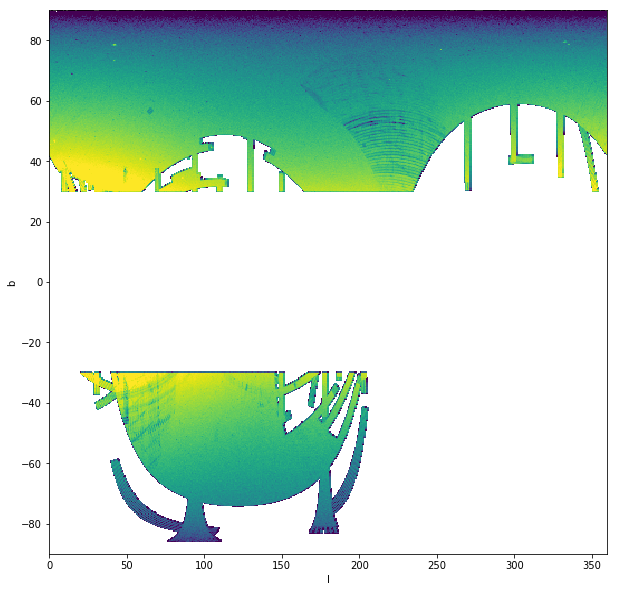

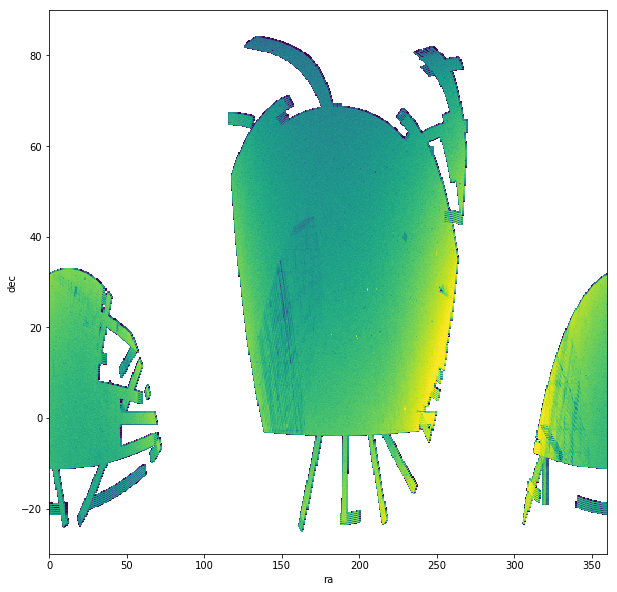

In [6]:
figGal, axGal = plotFootprint(stars['l'], stars['b'], None, nbins=500)
figEq, axEq = plotFootprint(stars['s_ra1'], stars['s_dec1'], None, nbins=500)
axGal.set_ylim(-90, 90)
axGal.set_xlabel('l')
axGal.set_ylabel('b')
axEq.set_ylim(-30, 90)
axEq.set_xlabel('ra')
axEq.set_ylabel('dec')

figGal.savefig('galview.png')
figEq.savefig('eqview.png')

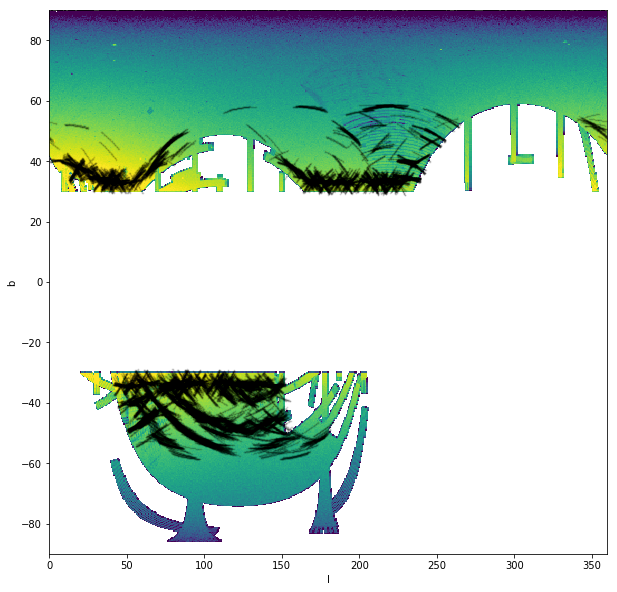

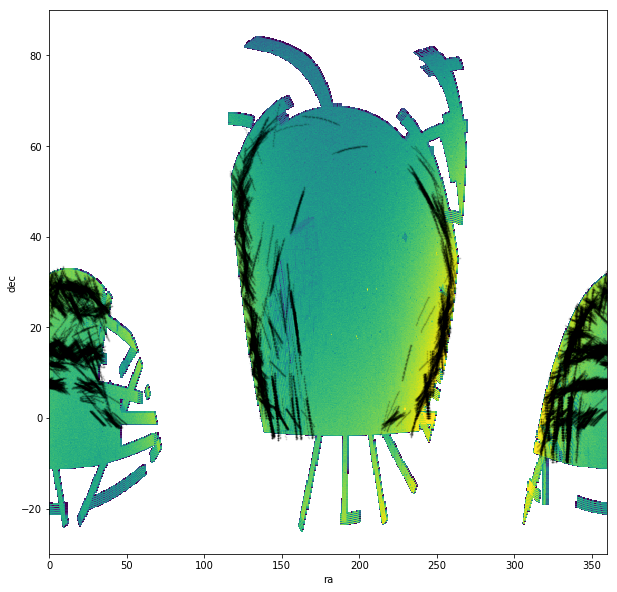

In [11]:
SNlow = [5]#[15, 10, 8, 6, 5]
SNhigh = [100000]#[100000, 15, 10, 8, 6]
for distance in ['10']:
    streamfile = 'detections_distance' + distance + '_nside128.txt'
    data = ascii.read(streamfile)
    for sl, sh in zip(SNlow, SNhigh):
        SNindex = data['n'] > 10
        #SNindex = (data['s2n']/data['n'] <= sh) & (data['s2n']/data['n'] > sl)
        filenameGal = 'galView_SN{0}to{1}_distance{2}kpc.png'.format(sl, sh, distance)
        filenameEq = 'eqView_SN{0}to{1}_distance{2}kpc.png'.format(sl, sh, distance)
        if not os.path.isfile(filenameEq):
            plotStream(stars['l'], stars['b'], stars['s_ra1'], stars['s_dec1'], 
                       data['l'][SNindex], data['b'][SNindex], data['phi1'][SNindex],
                       filenameGal =filenameGal, filenameEq = filenameEq)

(array([  3.20200000e+03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.40900000e+03,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   9.06000000e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   5.42000000e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.69000000e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.41000000e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.40000000e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   8.70000000e+01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   6.50000000e+01,
        

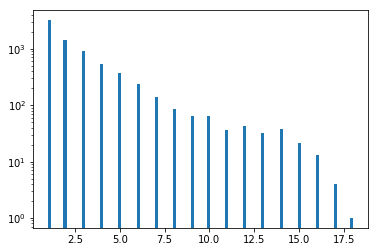

In [12]:
plt.hist(data['n'], bins=100, log=True)

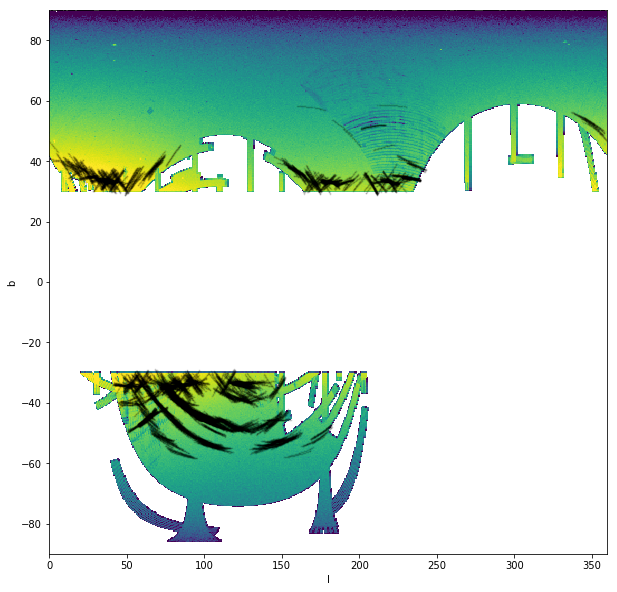

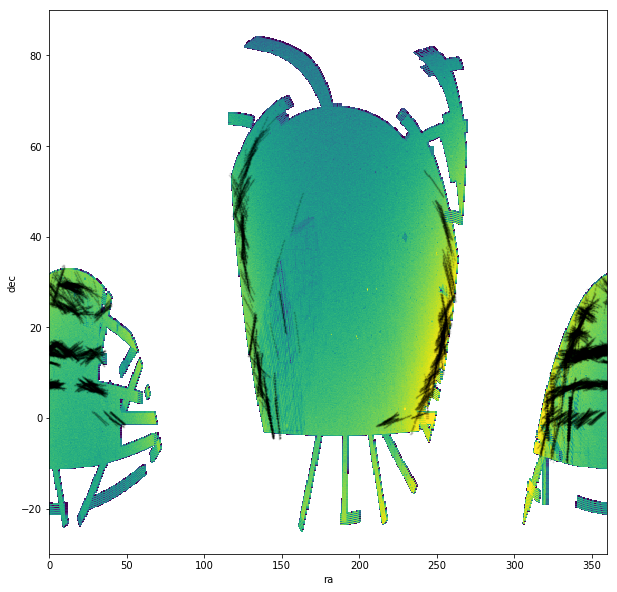

In [17]:
n_thresh = [2]
distances = ['10']
for distance in distances:
    streamfile = 'detections_distance' + distance + '_nside128.txt'
    data = ascii.read(streamfile)
    for nmin in n_thresh:
        index = data['n'] == nmin
        filenameGal = 'galView_nonly{0}_distance{1}kpc.png'.format(nmin, distance)
        filenameEq = 'eqView_nonly{0}_distance{1}kpc.png'.format(nmin, distance)
        if not os.path.isfile(filenameEq):
            plotStream(stars['l'], stars['b'], stars['s_ra1'], stars['s_dec1'], 
                       data['l'][index], data['b'][index], data['phi1'][index],
                       filenameGal =filenameGal, filenameEq = filenameEq)

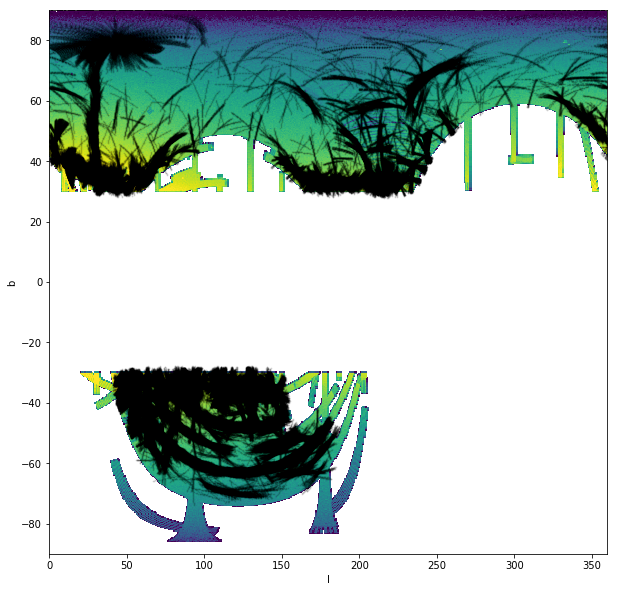

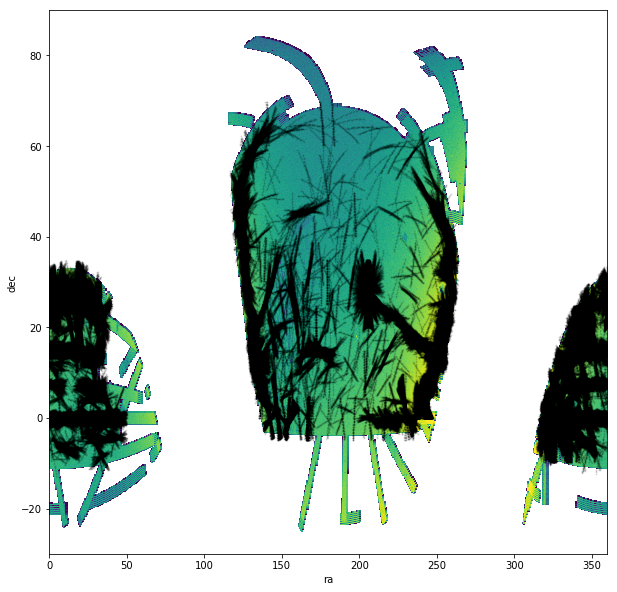

In [35]:
SNindex = (data['s2n'] <= 10) & (data['s2n'] > 5)
figGal, axGal = plotFootprint(stars['l'], stars['b'], None, nbins=500)
figEq, axEq = plotFootprint(stars['s_ra1'], stars['s_dec1'], None, nbins=500)
phi1 = np.linspace(0, 360.00001, 1024)
phi2 = np.zeros(len(phi1))
for lpole, bpole, phi1mid in zip(data['l'][SNindex], data['b'][SNindex], data['phi1'][SNindex]):
    pole = coord.Galactic(l=lpole*u.deg, b=bpole*u.deg)
    index = (phi1 <= phi1mid+5) & (phi1 >= phi1mid-5)
    testobserved = ArbitraryPoleFrame(phi1=phi1[index]*u.deg, phi2=phi2[index]*u.deg, pole=pole)
    gal = testobserved.transform_to(coord.Galactic)
    eq = testobserved.transform_to(coord.ICRS)
    axGal.scatter(gal.l, gal.b, s=1, alpha=0.1, c='black')
    axEq.scatter(eq.ra, eq.dec, s=1, alpha=0.1, c='black')
for ax in [axGal, axEq]: ax.set_xlim(0, 360)
axGal.set_ylim(-90, 90)
axGal.set_xlabel('l')
axGal.set_ylabel('b')
axEq.set_ylim(-30, 90)
axEq.set_xlabel('ra')
axEq.set_ylabel('dec')
figGal.savefig('SNgalview_5to8.png')
figEq.savefig('SNeqview_5to8.png')